<a href="https://colab.research.google.com/github/kevyntoro29/pneumothorax_segmentation/blob/main/dicom_to_npy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DRIVE - LIBRARIES**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Descomprimir el ZIP y llevarlo a una carpeta
import os
import zipfile
comprimido = zipfile.ZipFile('/content/drive/MyDrive/Dataset_medium_zip/archive.zip','r')
comprimido.extractall()
comprimido.close()

In [ ]:
from glob import glob
import pandas as pd
from tqdm import tqdm
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 7.4 MB/s 


In [ ]:
import pydicom

#**PATH - FUNCTIONS**

In [ ]:
train_path_cut_colab = '/content/siim/dicom-images-train/'
test_path_cut_colab = '/content/siim/dicom-images-test/'

In [ ]:
dicom_train_path = '/content/siim/dicom-images-train/*/*/*.dcm'
dicom_test_path = '/content/siim/dicom-images-test/*/*/*.dcm'
train_rle_csv = '/content/siim/train-rle.csv'

dicom_train = sorted(glob(dicom_train_path))
dicom_test = sorted(glob(dicom_test_path))
print("Número de muestras DICOM para el set de entrenamiento: ", len(dicom_train))
print("Número de muestras DICOM para el set de pruebas: ", len(dicom_test))
pd.reset_option('max_colwidth')
masks_rle = pd.read_csv(train_rle_csv, delimiter=",")
masks_rle.columns = ['ImageId', 'EncodedPixels']
masks_rle.head(10)

Número de muestras DICOM para el set de entrenamiento:  12089
Número de muestras DICOM para el set de pruebas:  3205


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...
5,1.2.276.0.7230010.3.1.4.8323329.11444.15178752...,-1
6,1.2.276.0.7230010.3.1.4.8323329.32219.15178751...,-1
7,1.2.276.0.7230010.3.1.4.8323329.32395.15178751...,-1
8,1.2.276.0.7230010.3.1.4.8323329.10623.15178752...,-1
9,1.2.276.0.7230010.3.1.4.8323329.12095.15178752...,-1


In [ ]:
def dicom_to(data, file_path, masks_rle, enco_pixels=True):

    pd.reset_option('max_colwidth')
    patient = {}
    patient["UID"] = data.SOPInstanceUID
    
    if enco_pixels:

      encoded_pixels = masks_rle[masks_rle["ImageId"] == data.SOPInstanceUID]["EncodedPixels"].values  
      patient["EncodedPixels"] = encoded_pixels
    
        
    patient["Age"] = data.PatientAge
    patient["Sex"] = data.PatientSex
    patient["Modality"] = data.Modality
    patient["BodyPart"] = data.BodyPartExamined
    patient["ViewPosition"] = data.ViewPosition
    
    if enco_pixels:
      pneumothorax = False

      for enco_pixels in encoded_pixels:
          if enco_pixels != '-1':
              pneumothorax = True
                
      patient['Diagnosis'] = pneumothorax
    
    if  enco_pixels:
        patient["path"] = train_path_cut_colab + data.StudyInstanceUID + "/" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"
    else:
        patient["path"] = test_path_cut_colab + data.StudyInstanceUID + "/" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"
    
    return patient

#**DATAFRAME**
METADATA AND PREPROCESSING
- https://www.kaggle.com/mbermejoa/tfm-codigo-mbermejoa

In [ ]:
patients_train = []

df_patients_train = pd.DataFrame()

for file_path in tqdm(dicom_train):
    data = pydicom.dcmread(file_path)
    patients_train_metadata = dicom_to(data, file_path, masks_rle)
    patients_train.append(patients_train_metadata)
df_patients_train = pd.DataFrame(patients_train)    

print("Número de imágenes DICOM verificadas (con información/relación) en el set de entrenamiento: ", df_patients_train.shape[0])

df_patients_train.head(10)

100%|██████████| 12089/12089 [00:45<00:00, 265.38it/s]


Número de imágenes DICOM verificadas (con información/relación) en el set de entrenamiento:  12089


,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,Diagnosis,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,[-1],38,M,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,[-1],10,F,CR,CHEST,AP,False,/content/siim/dicom-images-train/1.2.276.0.723...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,[-1],50,F,CR,CHEST,AP,False,/content/siim/dicom-images-train/1.2.276.0.723...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,[-1],68,F,CR,CHEST,AP,False,/content/siim/dicom-images-train/1.2.276.0.723...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,[-1],65,M,CR,CHEST,AP,False,/content/siim/dicom-images-train/1.2.276.0.723...
5,1.2.276.0.7230010.3.1.4.8323329.10004.15178752...,[-1],45,F,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...
6,1.2.276.0.7230010.3.1.4.8323329.10005.15178752...,[209126 1 1019 6 1015 10 1012 13 1010 14 1008 ...,53,F,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
7,1.2.276.0.7230010.3.1.4.8323329.10006.15178752...,[-1],55,M,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...
8,1.2.276.0.7230010.3.1.4.8323329.10007.15178752...,[-1],26,F,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...
9,1.2.276.0.7230010.3.1.4.8323329.10008.15178752...,[-1],63,M,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...


In [ ]:
missing = 0

for file_path in dicom_train:
    data = pydicom.dcmread(file_path)
    pat = {}
    pat["UID"] = data.SOPInstanceUID
    try:
        masks_rle[masks_rle["ImageId"] == pat["UID"]].values[0][1]
    except:
        missing = missing + 1
        
print("Número de imágenes DICOM del set de entrenamiento sin información de máscara RLE: ", missing)

Número de imágenes DICOM del set de entrenamiento sin información de máscara RLE:  42


In [ ]:
print("Número de muestras DICOM listadas en el fichero .csv train_rle: ", len(masks_rle))
print("Diferencia imágenes DICOM localizadas entre .csv y carpeta: ", len(masks_rle) - len(dicom_train))

Número de muestras DICOM listadas en el fichero .csv train_rle:  12954
Diferencia imágenes DICOM localizadas entre .csv y carpeta:  865


In [ ]:
patients_test = []
df_patients_test = pd.DataFrame()

for file_path in tqdm(dicom_test):
    data = pydicom.dcmread(file_path)
    patients_test_metadata = dicom_to(data, file_path, masks_rle, enco_pixels=False)
    patients_test.append(patients_test_metadata)
df_patients_test = pd.DataFrame(patients_test)    

print("Número de imágenes DICOM verificadas (con información/relación) en el set de prueba: ", df_patients_test.shape[0])

df_patients_test.head(10)

100%|██████████| 3205/3205 [00:06<00:00, 467.57it/s]

Número de imágenes DICOM verificadas (con información/relación) en el set de prueba:  3205


,UID,Age,Sex,Modality,BodyPart,ViewPosition,path
0,ID_0011fe81e,64,F,CR,CHEST,PA,/content/siim/dicom-images-test///ID_0011fe81e...
1,ID_003206608,47,M,CR,CHEST,PA,/content/siim/dicom-images-test///ID_003206608...
2,ID_004d6fbb6,62,M,CR,CHEST,AP,/content/siim/dicom-images-test///ID_004d6fbb6...
3,ID_004d72c54,45,M,CR,CHEST,AP,/content/siim/dicom-images-test///ID_004d72c54...
4,ID_00528aa0e,38,F,CR,CHEST,AP,/content/siim/dicom-images-test///ID_00528aa0e...
5,ID_00593ac6d,63,M,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00593ac6d...
6,ID_00b0e5a9f,62,F,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00b0e5a9f...
7,ID_00b115bfe,24,F,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00b115bfe...
8,ID_00d054471,22,F,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00d054471...
9,ID_00f04769e,33,M,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00f04769e...


In [ ]:
df_pats_train = []
df_pats_train = df_patients_train.drop(df_patients_train[df_patients_train['Age']==413].index)
df_pats_train = df_pats_train.drop(df_pats_train[df_pats_train['Age']==148].index)
print("Número de muestras del dataframe patients considerando todas las muestras: ", len(df_patients_train))
print("Número de muestras del dataframe pats sin considerar los outliers de edad: ", len(df_pats_train))

Número de muestras del dataframe patients considerando todas las muestras:  12089
Número de muestras del dataframe pats sin considerar los outliers de edad:  12089


#**DECODING THE MASK**
RLE2MASK AND MASK2RLE FUNCTION BY KAGGLE
- https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data

In [ ]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [ ]:
df_pneumo_train = df_pats_train[df_pats_train["Diagnosis"] == True]
display(df_pneumo_train)

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,Diagnosis,path
6,1.2.276.0.7230010.3.1.4.8323329.10005.15178752...,[209126 1 1019 6 1015 10 1012 13 1010 14 1008 ...,53,F,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
13,1.2.276.0.7230010.3.1.4.8323329.10011.15178752...,[49820 3 1017 11 1012 13 1009 16 1007 18 1006 ...,77,M,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
14,1.2.276.0.7230010.3.1.4.8323329.10012.15178752...,[261328 6 1015 11 1011 15 1007 18 1004 21 1002...,74,F,CR,CHEST,AP,True,/content/siim/dicom-images-train/1.2.276.0.723...
18,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,[592184 33 976 58 956 73 941 88 926 102 917 10...,57,F,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
28,1.2.276.0.7230010.3.1.4.8323329.10025.15178752...,[530522 1 1022 3 1019 6 1017 7 1016 9 1014 10 ...,30,F,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
...,...,...,...,...,...,...,...,...,...
12071,1.2.276.0.7230010.3.1.4.8323329.7037.151787520...,[643446 1 1022 5 1017 8 1015 9 1014 10 1012 12...,57,M,CR,CHEST,AP,True,/content/siim/dicom-images-train/1.2.276.0.723...
12073,1.2.276.0.7230010.3.1.4.8323329.7039.151787520...,[757984 1 4098 1 1024 2 1022 4 1021 4 1021 4 1...,52,M,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
12076,1.2.276.0.7230010.3.1.4.8323329.7041.151787520...,[400668 3 1016 10 1012 13 1008 17 1005 20 1003...,73,F,CR,CHEST,AP,True,/content/siim/dicom-images-train/1.2.276.0.723...
12080,1.2.276.0.7230010.3.1.4.8323329.7045.151787520...,[588992 2 1018 9 1012 15 1007 20 1003 23 999 2...,28,M,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...


In [ ]:
masks = {}
for index, row in df_patients_train[df_patients_train['Diagnosis'] == True].iterrows():
    masks[row['UID']] = list(row['EncodedPixels'])

In [ ]:
n_samp_train = len(dicom_train)

cont = 0
for i, file_path in tqdm(enumerate(dicom_train), total=n_samp_train):
    dataset = pydicom.read_file(file_path)
    
    try:
        img_id = file_path.split('/')[-1][:-4]
        img_id_indx = masks_rle[masks_rle['ImageId'] == img_id].index
        
        if len(img_id_indx) == 0:
            if cont == 0:
                without_rle_data = df_patients_train[df_patients_train['UID'] == img_id].index
                df_train = df_patients_train.drop(without_rle_data)
            else:
                without_rle_data = df_patients_train[df_patients_train['UID'] == img_id].index
                df_train = df_train.drop(without_rle_data)
            cont = cont + 1
        else:
            df_train = pd.DataFrame(df_patients_train)
            
    except:
        pass

100%|██████████| 12089/12089 [00:35<00:00, 339.94it/s]


In [ ]:
val_size = 0.2 
X_train, X_val, y_train, y_val = train_test_split(df_train.index, df_train['Diagnosis'].values, test_size=val_size, random_state=42)
X_train, X_val = df_train.loc[X_train]['path'].values, df_train.loc[X_val]['path'].values

#**DATA TRAIN NPY**

In [ ]:
prueba = X_train
print(len(prueba))

In [ ]:
img_npy = []
mask_npy = []

count = 0

for file_path in tqdm(prueba):   

    id = file_path.split('/')[-1][:-4]
    rle_temp = df_patients_train.loc[df_patients_train['UID'] == id].index.tolist()
    rle = df_pats_train['EncodedPixels'][rle_temp[0]]
    count = count + 1    

    image = pydicom.read_file(file_path).pixel_array
    image_resized = cv2.resize(image, (256, 256))

    image_resized = np.array(image_resized, dtype=np.float64)
    image_resized = cv2.normalize(image_resized, None, 0, 255, cv2.NORM_MINMAX)
    img_npy.append(image_resized)

    if len(rle) == 0:
        mask = np.zeros((1024, 1024), dtype=np.float32)
        
    elif rle[0] == '-1':
        mask = np.zeros((1024, 1024), dtype=np.float32)
    
    else:
        if len(rle) == 1:
            mask = rle2mask(rle[0], 1024, 1024).T
        else: 
            mask = np.zeros((1024, 1024), dtype=np.float32)
            for r in rle:
                mask =  mask + rle2mask(r, 1024, 1024).T
                
    mask_resized = cv2.resize(mask, (256, 256))
    mask_npy.append(mask_resized)
    
img_npy = np.uint8(img_npy)
mask_npy = np.uint8(mask_npy)


100%|██████████| 9671/9671 [03:48<00:00, 42.40it/s]


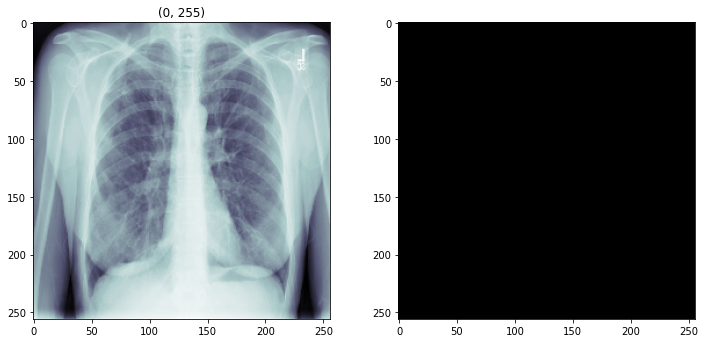

In [ ]:
d = 0
rango_X = np.amin(img_npy),np.amax(img_npy)
rango_y = np.amin(mask_npy),np.amax(mask_npy)
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_npy[d], cmap=plt.cm.bone)
ax1.set_title(rango_X)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask_npy[d], cmap = plt.cm.bone)

In [ ]:
X_train_npy = np.array(img_npy)
np.save("X_train.npy",X_train_npy)

In [ ]:
y_train_npy = np.array(mask_npy)
np.save("y_train.npy",y_train_npy)

#**DATA VAL NPY**

In [ ]:
prueba = X_val
print(len(prueba))

In [ ]:
img_npy = []
mask_npy = []

count = 0

for file_path in tqdm(prueba):   

    id = file_path.split('/')[-1][:-4]

    rle_temp = df_patients_train.loc[df_patients_train['UID'] == id].index.tolist()
    rle = df_pats_train['EncodedPixels'][rle_temp[0]]
    count = count + 1

    image = pydicom.read_file(file_path).pixel_array
    image_resized = cv2.resize(image, (256, 256))
    image_resized = np.array(image_resized, dtype=np.float64)

    image_resized = cv2.normalize(image_resized, None, 0, 255, cv2.NORM_MINMAX)
    img_npy.append(image_resized)

    if len(rle) == 0:
        mask = np.zeros((1024, 1024), dtype=np.float32)
        
    elif rle[0] == '-1':
        mask = np.zeros((1024, 1024), dtype=np.float32)
    
    else:
        if len(rle) == 1:
            mask = rle2mask(rle[0], 1024, 1024).T
        else: 
            mask = np.zeros((1024, 1024), dtype=np.float32)
            for r in rle:
                mask =  mask + rle2mask(r, 1024, 1024).T
                
    mask_resized = cv2.resize(mask, (256, 256))
    mask_npy.append(mask_resized)

img_npy = np.uint8(img_npy)
mask_npy = np.uint8(mask_npy)


100%|██████████| 2418/2418 [01:14<00:00, 32.47it/s]


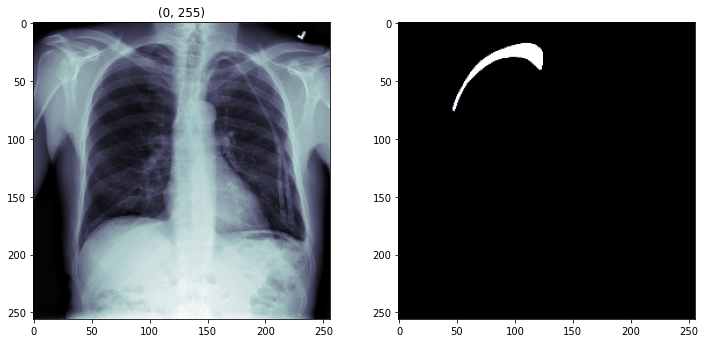

In [ ]:
d = 2
rango_X = np.amin(img_npy),np.amax(img_npy)
rango_y = np.amin(mask_npy),np.amax(mask_npy)
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_npy[d], cmap=plt.cm.bone)
ax1.set_title(rango_X)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask_npy[d], cmap = plt.cm.bone)

In [ ]:
X_val_npy = np.array(img_npy)
np.save("X_val.npy",X_val_npy)

In [ ]:
y_val_npy = np.array(mask_npy)
np.save("y_val.npy",y_val_npy)